In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib


In [2]:
from PIL import Image
import os
import numpy as np

path_to_files = "Data" 
array_of_images = []
array_of_Y = []
for _, file in enumerate(os.listdir(path_to_files)):
    if "close" in file: # to check if file has a certain name  
        try:
            single_im = Image.open(path_to_files + "/" + file)
            single_array = np.array(single_im)
            array_of_images.append(single_array)
            array_of_Y.append("Closed")
        except:
            print()
    else:
        try:
        
            single_im = Image.open(path_to_files + "/" + file)
            single_array = np.array(single_im)
            array_of_images.append(single_array) 
            array_of_Y.append("Open")
        except:
            print()
np.savez("all_images.npz",array_of_images,array_of_Y) # save all in one file

c:\Users\OBachar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [3]:
data = np.load("all_images.npz", allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']
X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

4000
4000


In [245]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)

4000
(32, 32, 3)


In [246]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(4000,)
0
{0, 1}


In [247]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(4000, 32, 32, 3)
(4000,)


In [248]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

In [249]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3400, 32, 32, 3)
(3400,)
(600, 32, 32, 3)
(600,)
(3400, 32, 32, 3)
(3400, 2)
(600, 32, 32, 3)
(600, 2)


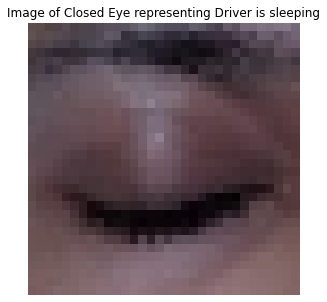

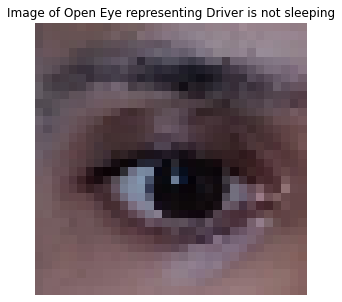

In [250]:
# 0 - Closed
# 1 - Open
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

C:\Users\OBachar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


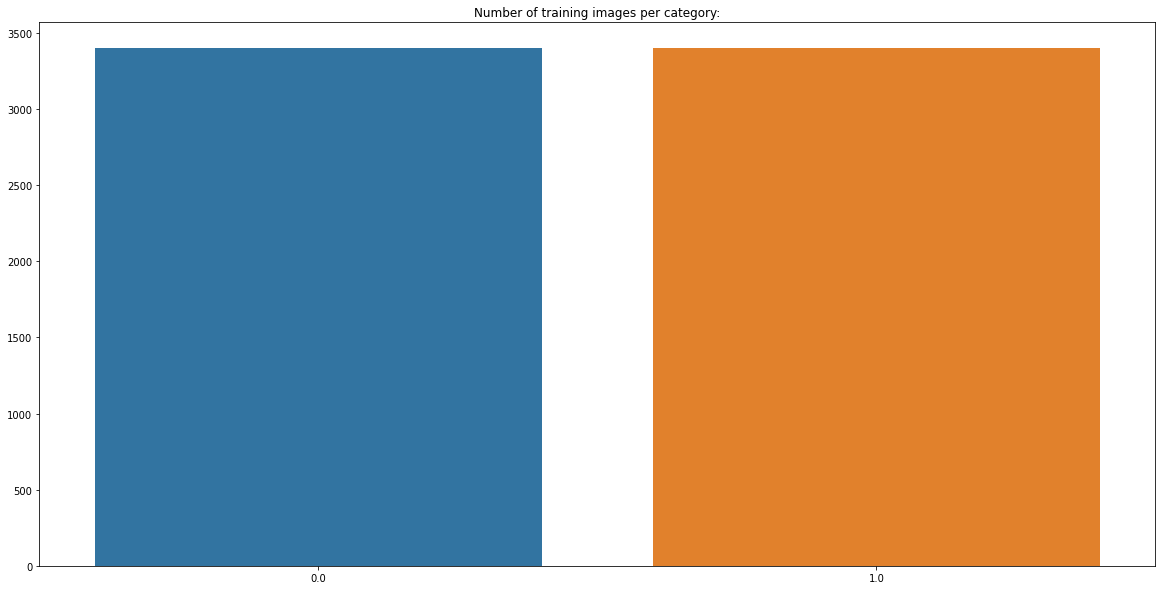

In [251]:
unique_train, count = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_train, count).set_title("Number of training images per category:")
plt.show()

C:\Users\OBachar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


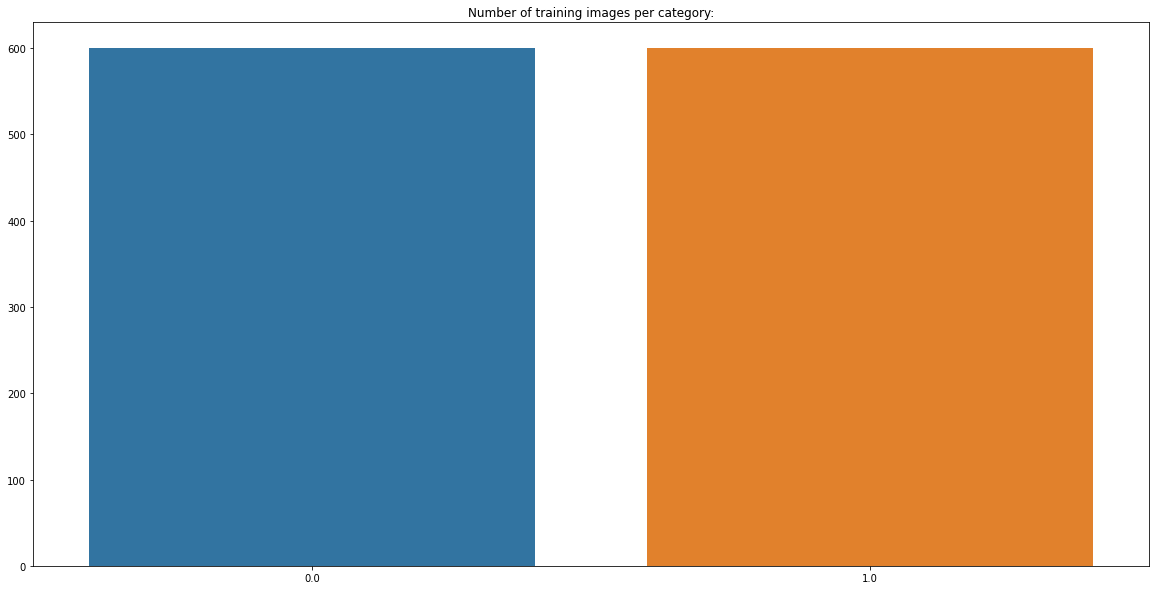

In [252]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_test, count_test).set_title("Number of training images per category:")
plt.show()

In [253]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [254]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_91 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_92 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_65 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 16, 16, 32)     

In [255]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=200, validation_data=(X_test, Y_test))

Epoch 1/200
27/27 [==============================] - 19s 667ms/step - loss: 1.3227 - accuracy: 0.5088 - val_loss: 0.6830 - val_accuracy: 0.5433
Epoch 2/200
27/27 [==============================] - 17s 618ms/step - loss: 0.9862 - accuracy: 0.5609 - val_loss: 0.6746 - val_accuracy: 0.5717
Epoch 3/200
27/27 [==============================] - 17s 623ms/step - loss: 0.8667 - accuracy: 0.5803 - val_loss: 0.6512 - val_accuracy: 0.5767
Epoch 4/200
27/27 [==============================] - 17s 628ms/step - loss: 0.7840 - accuracy: 0.6074 - val_loss: 0.6391 - val_accuracy: 0.5717
Epoch 5/200
27/27 [==============================] - 17s 616ms/step - loss: 0.6976 - accuracy: 0.6471 - val_loss: 0.6212 - val_accuracy: 0.6167
Epoch 6/200
27/27 [==============================] - 17s 613ms/step - loss: 0.6578 - accuracy: 0.6759 - val_loss: 0.5931 - val_accuracy: 0.6500
Epoch 7/200
27/27 [==============================] - 17s 633ms/step - loss: 0.5883 - accuracy: 0.7135 - val_loss: 0.5238 - val_accuracy:

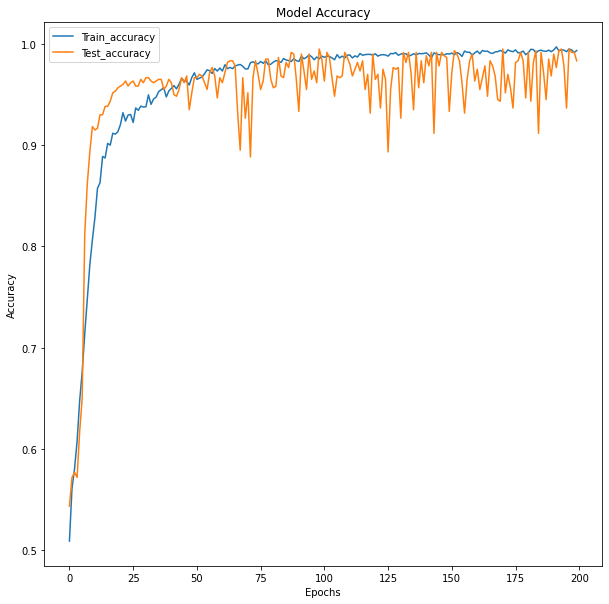

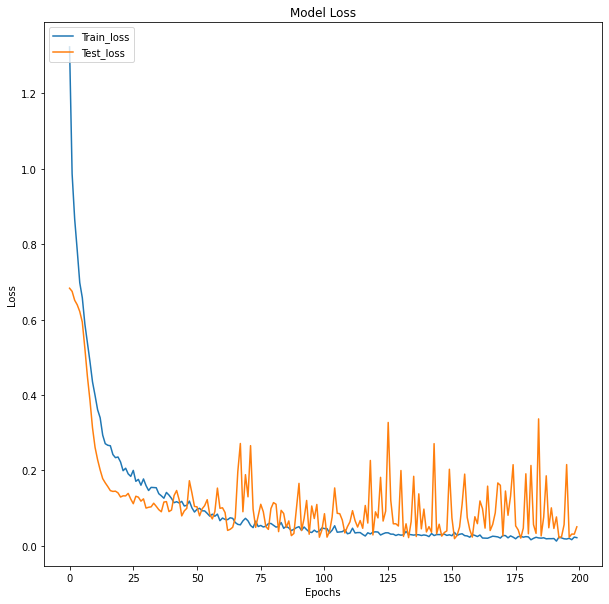

In [256]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [257]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

19/19 [==============================] - 1s 36ms/step - loss: 0.0505 - accuracy: 0.9833
Test Set Accuracy: 0.9833333492279053
Test Set Loss: 0.050494369119405746


In [258]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       281
           1       1.00      0.97      0.98       319

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



<AxesSubplot:>

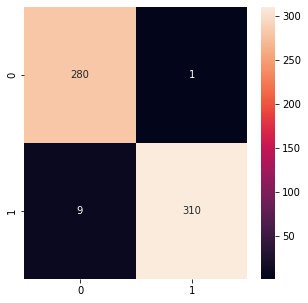

In [259]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [260]:
model.save('finalmodel.h5')